In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import semopy

import matplotlib.pyplot as plt

from lingam import DirectLiNGAM
from lingam.utils import make_dot, remove_effect, calculate_total_effect, print_causal_directions, print_dagc
from lingam.bootstrap import BootstrapResult

import networkx as nx
import graphviz as gv
from IPython.display import display, Image, Markdown

np.random.seed(0)

## 準備

[adaptive_logistic_regression](https://github.com/cdt15/ada_logistic_reg)のコードを持ってきておく。あらかじめRやglmnetはインストールしておく必要がある。

In [2]:
import requests

def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

dirname = "ada_log_reg"
if os.path.isdir(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)

_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/_adaptive_logistic_regression.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/adaptive_logistic_regression.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/__init__.py", dirname=dirname)

from ada_log_reg import predict_adaptive_logistic_regression

## グラフ描画用関数

In [3]:
def draw(adj):
    """ グラフ描画
    adj : pandas.DataFramne
        カラム名は X{セット番号}_{変数番号} の形式であること。
    """
    g = gv.Digraph()

    cluster_names = np.array([c.split("_")[0][1:] for c in adj.columns])
    for cluster_name in set(cluster_names):
        with g.subgraph(name=f"cluster_{cluster_name}") as sub:
            for index in np.argwhere(cluster_names == cluster_name).ravel():
                sub.node(adj.columns[index], adj.columns[index])
            sub.attr(label=f"set{cluster_name}")

    for to, coefs in adj.iterrows():
        for from_index, coef in enumerate(coefs):
            if np.isclose(coef, 0):
                continue
            g.edge(adj.columns[from_index], to, label=f"{coef}")
            
    return g

## テストデータ生成

### グラフ作成

,x1_0,x1_1,x1_2,x2_0,x2_1,x2_2,x2_3,x2_4,x3_0
x1_0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
x1_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
x1_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
x2_0,0.82,0.00,1.45,0.00,0.00,0.00,0.00,0.00,0.0
x2_1,0.00,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.0
x2_2,-1.17,0.00,0.00,1.29,-1.03,0.00,0.00,0.00,0.0
x2_3,0.00,0.56,0.00,-0.59,-0.52,-1.33,0.00,0.00,0.0
x2_4,-0.52,0.00,-1.48,0.00,0.00,-0.96,0.00,0.00,0.0
x3_0,0.00,0.00,0.00,0.00,0.00,0.00,-0.77,-1.24,0.0


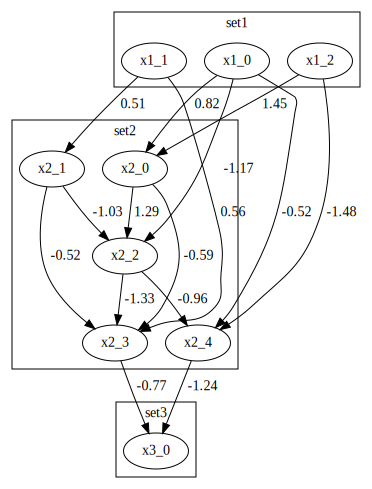

In [4]:
# -- 設定 -------------------------------

# サンプルサイズ
n_samples = 1000

# 外生変数は離散と連続が混在
n_vars_set1 = 3
# 内生変数は連続のみ
n_vars_set2 = 5
# シンクの離散変数
n_vars_set3 = 1

# ------------------------------------

n_vars = n_vars_set1 + n_vars_set2 + n_vars_set3

# 各変数の係数のリストを追加していく
adj = []

# set1は外生なのですべて0
for i in range(n_vars_set1):
    adj.append(np.zeros(n_vars))

# set2内の因果グラフを作成
adj_set2 = np.random.uniform(0.5, 1.5, size=(n_vars_set2, n_vars_set2))
adj_set2 *= np.random.choice([-1, 1], size=(n_vars_set2, n_vars_set2))
adj_set2 *= np.tri(5, k=-1)

# 少しスパースに。
ratio = 0.5
for i in range(n_vars_set2):
    adj_set2[i] *= np.random.choice([0, 1], p=[ratio, 1 - ratio], size=n_vars_set2)
    
# set1とset2の関係を作成
adj_set1_to_set2 = np.random.uniform(0.5, 1.5, size=(n_vars_set2, n_vars_set1))
adj_set1_to_set2 *= np.random.choice([-1, 1], size=(n_vars_set2, n_vars_set1))

# 少しスパースに。ただし必ずset1を一つは親に持つようにしておく。
filter_ = np.random.choice([0, 1], size=adj_set1_to_set2.shape)
for i, row in enumerate(filter_):
    if (~np.isclose(row, 0)).any():
        continue
    pos = np.random.choice(np.arange(n_vars_set1))
    filter_[i, pos] = 1
adj_set1_to_set2 *= filter_

# set2の隣接行列は上2つの行列をヨコにつなげたもの
adj_set2 = np.concatenate([adj_set1_to_set2, adj_set2], axis=1)
# さらにset3の分も追加
adj_set2 = np.concatenate([adj_set2, np.zeros((len(adj_set2), 1))], axis=1)

# set2を追加
for i in range(n_vars_set2):
    adj.append(adj_set2[i])

# set3

# set2は確率的にset3の親になる
par_filter = np.random.choice([0, 1], size=n_vars_set2)
par_filter = np.concatenate([np.zeros(n_vars_set1), par_filter, [0]])

# set2のシンクは必ず親
index = np.argwhere(np.isclose(np.array(adj), 0).all(axis=0)).ravel()
par_filter[index] = 1
par_filter[-1] = 0

adj_set3 = np.random.uniform(0.5, 1.5, size=n_vars)
adj_set3 *= np.random.choice([-1, 1], size=n_vars)
adj_set3 *= par_filter
adj.append(adj_set3)

# 丸める
adj = np.round(adj, decimals=2)
adj[np.isclose(adj, 0)] = 0

var_names = [
    *[f"x1_{i}" for i in range(n_vars_set1)],
    *[f"x2_{i}" for i in range(n_vars_set2)],
    *[f"x3_{i}" for i in range(n_vars_set3)],
]
adj = pd.DataFrame(adj, columns=var_names, index=var_names)

display(adj)

#make_dot(adj, labels=adj.columns.tolist())
draw(adj)

### データ作成

x1_2とx3_0は離散変数。

In [5]:
is_discrete = [c == "x1_2" or c == "x3_0" for c in adj.columns]

dag = nx.from_numpy_array(adj.values.T, create_using=nx.DiGraph)
causal_ordered = list(nx.topological_sort(dag))

X = np.zeros((n_vars, n_samples))
for co in causal_ordered:
    if not is_discrete[co]:
        X[co, :] = adj.iloc[co] @ X + np.random.uniform(-1.732, 1.732, size=n_samples)
    else:
        mask = np.random.uniform(0, 1, size=n_samples)
        X[co, :] = expit(adj.iloc[co] @ X) >= mask

X = pd.DataFrame(X.T, columns=adj.columns)
X.loc[:, is_discrete] = X.loc[:, is_discrete].astype(int)

In [6]:
X.var()

x1_0     0.999141
x1_1     1.008038
x1_2     0.250214
x2_0     2.249262
x2_1     1.232052
x2_2     4.922029
x2_3    12.847885
x2_4     7.737761
x3_0     0.210610
dtype: float64

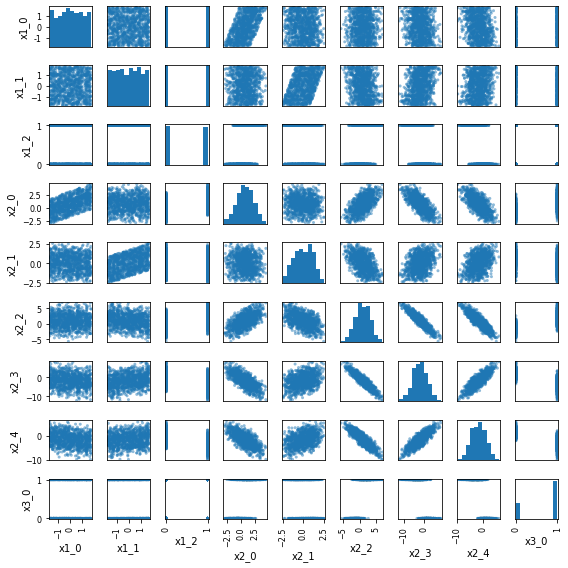

In [7]:
pd.plotting.scatter_matrix(X, figsize=(8, 8))
plt.tight_layout()
plt.show()

## 因果探索の実行

下記のノートブックから持ち込んだ。set3は離散変数ひとつだけになるので、その部分は省略している。
https://github.com/cdt15/lingam/blob/master/examples/Example_to_handle_groups_of_variables_with_known_causal_orders_btw_the_groups.ipynb

In [8]:
def run_causal_discovery(X, is_adaptive=True):
    set1_indices = np.argwhere([c.startswith("x1_") for c in X.columns]).ravel()
    X_removed_set1 = remove_effect(X, set1_indices)

    set2_indices = np.argwhere([c.startswith("x2_") for c in X.columns]).ravel()
    X2_resid = X_removed_set1[:, set2_indices]

    set2_model = DirectLiNGAM()
    set2_model.fit(X2_resid)

    predictors = set2_indices
    target = np.argwhere([c.startswith("x3_") for c in X.columns]).ravel()[0]
    
    if is_adaptive:
        # XXX: targetがint64だとエラー。チェックのミス。
        coefs = predict_adaptive_logistic_regression(X, predictors, int(target))
    else:
        model = LogisticRegression()
        model.fit(X.iloc[:, predictors], X.iloc[:, target])
        coefs = model.coef_
    
    adj = np.concatenate([set2_model.adjacency_matrix_, coefs])
    adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)
    
    names = X.columns[set2_indices.tolist() + [-1]]
    adj = pd.DataFrame(adj, columns=names, index=names)
    
    return adj

adaptiveな場合

In [9]:
adj = run_causal_discovery(X)
adj

,x2_0,x2_1,x2_2,x2_3,x2_4,x3_0
x2_0,0.00000,0.000000,0.000000,0.00000,0.000000,0.0
x2_1,0.00000,0.000000,0.000000,0.00000,0.000000,0.0
x2_2,1.27967,-0.996802,0.000000,0.00000,0.000000,0.0
x2_3,-0.54159,-0.524126,-1.352651,0.00000,0.000000,0.0
x2_4,0.00000,0.000000,-0.945557,0.00000,0.000000,0.0
x3_0,0.00000,0.000000,0.000000,-0.81459,-1.053659,0.0


adaptiveでない場合

In [10]:
adj = run_causal_discovery(X, is_adaptive=False)
adj

,x2_0,x2_1,x2_2,x2_3,x2_4,x3_0
x2_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x2_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x2_2,1.279670,-0.996802,0.000000,0.000000,0.000000,0.0
x2_3,-0.541590,-0.524126,-1.352651,0.000000,0.000000,0.0
x2_4,0.000000,0.000000,-0.945557,0.000000,0.000000,0.0
x3_0,-0.012072,-0.154364,0.040287,-0.824696,-1.033912,0.0


## ブートストラップ

エッジやパスのブートストラップ確率と適合度を計算する。

In [11]:
def run_bootstrap(X, n_sampling=10, is_adaptive=True):
    set2_vars = np.argwhere([c.startswith("x2_") for c in X.columns]).ravel()
    set3_vars = np.argwhere([c.startswith("x3_") for c in X.columns]).ravel()
    target_vars = [*set2_vars, *set3_vars]
    
    adjs = np.zeros((n_sampling, len(target_vars), len(target_vars)))
    total_effects = np.zeros((n_sampling, len(target_vars), len(target_vars)))
    
    for i in range(n_sampling):
        X_ = resample(X)
        
        # 因果探索
        adj = run_causal_discovery(X_, is_adaptive=is_adaptive)
        adjs[i] = adj.values
        
        # 因果順序
        dag = nx.from_numpy_array(adj.values.T, create_using=nx.DiGraph)
        causal_order = list(nx.topological_sort(dag))
        
        # https://github.com/cdt15/lingam/blob/master/lingam/bootstrap.py#L52
        for c, from_ in enumerate(causal_order):
            for to in causal_order[c + 1 :]:
                total_effects[i, to, from_] = calculate_total_effect(
                    adj.values, from_, to
                )
    bs_result = BootstrapResult(adjs, total_effects)
    return bs_result

### 枝刈りあり

In [12]:
result = run_bootstrap(X)

In [13]:
# https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb

display(Markdown("### Causal Directions"))
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, 100)

display(Markdown("### Directed Acyclic Graphs"))
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, 100)

display(Markdown("### Probability"))
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

display(Markdown("### Total Causal Effects"))
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# Assign to pandas.DataFrame for pretty display
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
display(df)

display(Markdown("### Bootstrap Probability of Path"))
from_index = 1 # x2_1
to_index = 5 # x3_0
pd.DataFrame(result.get_paths(from_index, to_index))

### Causal Directions

x2 <--- x0 (b>0) (10.0%)
x2 <--- x1 (b<0) (10.0%)
x3 <--- x0 (b<0) (10.0%)
x3 <--- x1 (b<0) (10.0%)
x3 <--- x2 (b<0) (10.0%)
x4 <--- x2 (b<0) (10.0%)
x5 <--- x3 (b<0) (10.0%)
x5 <--- x4 (b<0) (10.0%)


### Directed Acyclic Graphs

DAG[0]: 8.0%
	x2 <--- x0 (b>0)
	x2 <--- x1 (b<0)
	x3 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x3 <--- x2 (b<0)
	x4 <--- x2 (b<0)
	x5 <--- x3 (b<0)
	x5 <--- x4 (b<0)
DAG[1]: 1.0%
	x2 <--- x0 (b>0)
	x2 <--- x1 (b<0)
	x3 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x3 <--- x2 (b<0)
	x4 <--- x2 (b<0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b<0)
	x5 <--- x4 (b<0)
DAG[2]: 1.0%
	x2 <--- x0 (b>0)
	x2 <--- x1 (b<0)
	x3 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x3 <--- x2 (b<0)
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x5 <--- x3 (b<0)
	x5 <--- x4 (b<0)


### Probability

[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [1.  1.  1.  0.  0.  0. ]
 [0.1 0.  1.  0.  0.  0. ]
 [0.  0.  0.1 1.  1.  0. ]]


### Total Causal Effects

,from,to,effect,probability
0,x0,x2,1.275683,1.0
1,x1,x2,-0.989590,1.0
2,x0,x3,-2.255167,1.0
3,x1,x3,0.811777,1.0
4,x2,x3,-1.348997,1.0
5,x0,x4,-1.188347,1.0
6,x1,x4,0.926314,1.0
7,x2,x4,-0.942821,1.0
8,x0,x5,3.145885,1.0
9,x1,x5,-1.667863,1.0


### Bootstrap Probability of Path

,path,effect,probability
0,"[1, 2, 3, 5]",-1.148378,1.0
1,"[1, 2, 4, 5]",-0.994191,1.0
2,"[1, 3, 5]",0.442149,1.0
3,"[1, 2, 5]",-0.516993,0.1


### 枝刈りなし

In [14]:
result = run_bootstrap(X, is_adaptive=False)

In [15]:
# https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb

display(Markdown("### Causal Directions"))
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, 100)

display(Markdown("### Directed Acyclic Graphs"))
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, 100)

display(Markdown("### Probability"))
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

display(Markdown("### Total Causal Effects"))
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# Assign to pandas.DataFrame for pretty display
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
display(df)

display(Markdown("### Bootstrap Probability of Path"))
from_index = 1 # x2_1
to_index = 5 # x3_0
pd.DataFrame(result.get_paths(from_index, to_index))

### Causal Directions

x2 <--- x0 (b>0) (10.0%)
x2 <--- x1 (b<0) (10.0%)
x3 <--- x0 (b<0) (10.0%)
x3 <--- x1 (b<0) (10.0%)
x3 <--- x2 (b<0) (10.0%)
x4 <--- x2 (b<0) (10.0%)
x5 <--- x3 (b<0) (10.0%)
x5 <--- x4 (b<0) (10.0%)


### Directed Acyclic Graphs

DAG[0]: 3.0%
	x2 <--- x0 (b>0)
	x2 <--- x1 (b<0)
	x3 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x3 <--- x2 (b<0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b>0)
	x5 <--- x1 (b<0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b<0)
	x5 <--- x4 (b<0)
DAG[1]: 1.0%
	x2 <--- x0 (b>0)
	x2 <--- x1 (b<0)
	x3 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x3 <--- x2 (b<0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b<0)
	x5 <--- x1 (b<0)
	x5 <--- x2 (b<0)
	x5 <--- x3 (b<0)
	x5 <--- x4 (b<0)
DAG[2]: 1.0%
	x2 <--- x0 (b>0)
	x2 <--- x1 (b<0)
	x3 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x3 <--- x2 (b<0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b<0)
	x5 <--- x1 (b>0)
	x5 <--- x2 (b<0)
	x5 <--- x3 (b<0)
	x5 <--- x4 (b<0)


### Probability

[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [1.  1.  1.  0.  0.  0. ]
 [0.3 0.1 1.  0.  0.  0. ]
 [1.  0.9 0.8 1.  1.  0. ]]


### Total Causal Effects

,from,to,effect,probability
0,x0,x2,1.263288,1.0
1,x1,x2,-0.981567,1.0
2,x0,x3,-2.287851,1.0
3,x1,x3,0.797990,1.0
4,x2,x3,-1.350350,1.0
5,x0,x4,-1.194094,1.0
6,x1,x4,0.939023,1.0
7,x2,x4,-0.962547,1.0
8,x0,x5,3.193920,1.0
9,x1,x5,-1.727994,1.0


### Bootstrap Probability of Path

,path,effect,probability
0,"[1, 2, 3, 5]",-1.060650,1.0
1,"[1, 2, 4, 5]",-0.933441,1.0
2,"[1, 2, 5]",-0.115004,1.0
3,"[1, 3, 5]",0.424709,1.0
4,"[1, 5]",-0.092707,1.0
5,"[1, 4, 5]",0.126391,0.1
